Student Name: Yuhang Peng <br>
Student ID:   34278818

# 2 Ridge Regression

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

## Question 4

### I

The error function for ridge regression (linear regression with L2 regularization) is given by:
$$
E(\mathbf{w}) = \frac{1}{2} \left\|\Phi \mathbf{w} - \mathbf{t} \right\|^2 + \frac{\lambda}{2} \|\mathbf{w}\|^2
$$

Here,
- $\Phi$ is the design matrix (each row is a data point, each column is a feature).
- $\mathbf{w}$ is the weight vector.
- $\mathbf{t}$ is the target vector.
- $\lambda$ is the regularization parameter.

To find the optimal $\mathbf{w}$, we take the derivative of the cost function with respect to $\mathbf{w}$ and set it to zero:
$$
\frac{\partial E(\mathbf{w})}{\partial \mathbf{w}} = \Phi^T (\Phi \mathbf{w} - \mathbf{t}) + \lambda \mathbf{w} = 0
$$

Now, rearrange the equation to solve for $\mathbf{w}$:
$$
\Phi^T \Phi \mathbf{w} + \lambda \mathbf{w} = \Phi^T \mathbf{t}
$$
$$
(\Phi^T \Phi + \lambda \mathbf{I}) \mathbf{w} = \Phi^T \mathbf{t}
$$
Where $\mathbf{I}$ is the identity matrix.

The solution for $\mathbf{w}$ is then given by:
$$
\mathbf{w} = (\Phi^T \Phi + \lambda \mathbf{I})^{-1} \Phi^T \mathbf{t}
$$
This is the closed-form solution for ridge regression.

### II

In [2]:
class RidgeRegressionSGD:

    def __init__(self, lambda_=0.1):
        """
        Initialize the Ridge Regression model.

        Parameters:
        - lambda_: Regularization strength for Ridge Regression (L2 penalty).
        """
        self.lambda_ = lambda_ # Regularization strength

    def fit(self, x, y):
        """
        Fit the Ridge Regression model to the training data using the closed-form solution.

        Parameters:
        - x: Feature matrix (n_samples, n_features).
        - y: Target vector (n_samples,).

        Returns:
        - self: The fitted model instance.
        """
        # Number of features
        p = x.shape[1]

        # Identity matrix of size p * p
        I = np.eye(p)

        # Compute the closed-form solution for Ridge Regression
        self.coef_ = np.linalg.inv(x.T.dot(x) + self.lambda_ * I).dot(x.T).dot(y)

        return self

    def predict(self, x):
        """
        Predict the target values using the fitted Ridge Regression model.

        Parameters:
        - x: Feature matrix (n_samples, n_features).

        Returns:
        - y_pred: Predicted values (n_samples,).
        """
        y_pred = x.dot(self.coef_) # Compute predictions as dot product of features and coefficients
        return y_pred

### III

#### (a)

In [3]:
def f(x):
    return np.cos(3 * np.pi * x)/(2 + 3 * x)

# Synthetic data generator
def make_additive_noise_data(n, f, a, b, noise=0.1, random_state=None):
    RNG = np.random.default_rng(random_state) # Random number generator
    x = RNG.uniform(a, b, size=(n, 1)) # Generate n points uniformly in the range [a,b]
    y = f(x) + RNG.normal(0, noise, size=(n, 1)) # Add Gaussian noise to the target values
    return x, y

# Polynomial feature transformer
class PolynomialFeatures:

    def __init__(self, degree):
        self.degree = degree # The degree of the polynomial features

    def fit(self, x, y=None):
        return self

    def transform(self, x, y=None):
        output = []
        for i in range(0, self.degree + 1):
            column = x ** i # Generate the i-th degree polynomial feature
            output.append(column)
        return np.column_stack(output) # Stack the columns to form the output matrix

    def fit_transform(self, x, y=None):
        self.fit(x, y) # Fit the transformer
        return self.transform(x, y) # Transform the data into polynomial features

#### (b)

In [4]:
# Define the range of lambda values 
lambda_values = np.geomspace(10**-10, 0.1, 101, endpoint=True)
n_repeats = 10 # Number of repeats for each lambda to reduce variability

# List to store errors across all repeats and lambda values
train_errors = []
test_errors = []

# Generate a fixed test dataset for evaluating the model
x_test, y_test = make_additive_noise_data(1000, f, -0.3, 0.3, random_state=42)

# Create pipelines for each lambda value
pipelines = [
    make_pipeline(
        PolynomialFeatures(degree=5), # Transform the data into polynomial features of degree 5
        RidgeRegressionSGD(lambda_=lambda_) # Ridge regression using SGD with specified lambda
    ) for lambda_ in lambda_values
]

# Repeat the experiment n_repeat times
for _ in range(n_repeats):
    # Generate new training data for each repeat
    x_train, y_train = make_additive_noise_data(20, f, -0.3, 0.3, noise=0.1, random_state=None)

    train_error_lambda = [] # List to store training errors for all lambda values in the current repeat
    test_error_lambda = [] # List to store test errors for all lambda values in the current repeat

    # Fit and evaluate each pipeline corresponding to each lambda value
    for j, lambda_ in enumerate(lambda_values):
        pipelines[j].fit(x_train, y_train) # Fit the model on the training data
        
        # Calculate training and test errors
        train_error = mean_squared_error(y_train, pipelines[j].predict(x_train))
        test_error = mean_squared_error(y_test, pipelines[j].predict(x_test))

        # Append errors for the current lambda
        train_error_lambda.append(train_error) 
        test_error_lambda.append(test_error) 
        
    # Store the errors for all lambdas in this repeat
    train_errors.append(train_error_lambda)
    test_errors.append(test_error_lambda)

#### (c)

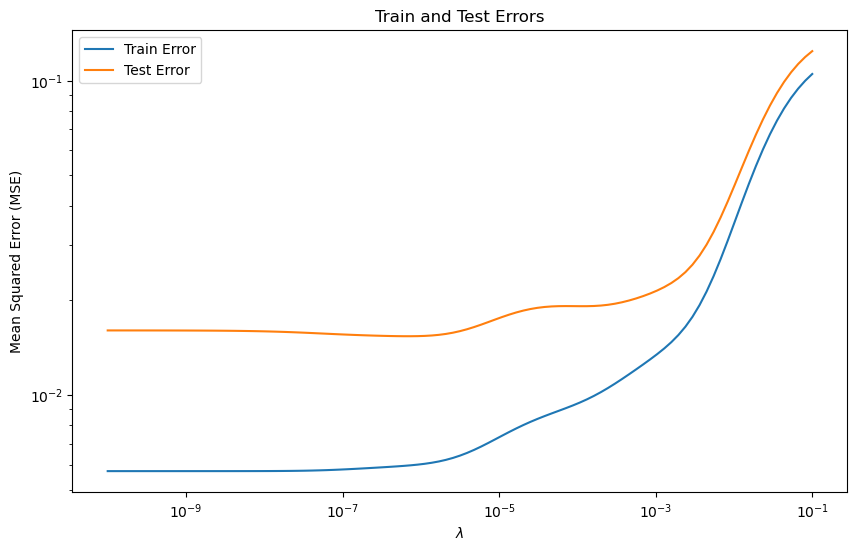

In [7]:
# Compute the mean of errors across all repeats for each lambda value
mean_train_errors = np.mean(train_errors, axis=0)
std_train_errors = np.std(train_errors, axis=0)
mean_test_errors = np.mean(test_errors, axis=0)
std_test_errors = np.std(test_errors, axis=0)

# Plotting the results
plt.figure(figsize=(10, 6))

# Plot the mean train and test errors
plt.plot(lambda_values, mean_train_errors, label='Train Error')
plt.plot(lambda_values, mean_test_errors, label='Test Error')

# Set log scale for x-axis and y-axis since lambda values are log-scaled
plt.xscale('log')
plt.yscale('log')

# Add labels and title
plt.xlabel(r'$\lambda$')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Train and Test Errors')
plt.legend()
plt.show()

- For small values of $\lambda$, the model has high complexity, and we start to see signs of overfitting as the training error is significantly lower than the test error.
- For large values of $\lambda$, the model becomes too simple, resulting in underfitting, as evidenced by the high error rates on both training and test sets.